In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(0)

## Goal

* predict next close price with 7 days data

In [2]:
df = pd.read_csv('data/stock_daily.csv').iloc[::-1] # time ascending order
df

,Open,High,Low,Volume,Close
731,568.002570,568.002570,552.922516,13100,558.462551
730,561.202549,566.432590,558.672539,41200,559.992565
729,566.892592,567.002574,556.932537,10800,556.972503
728,558.712504,568.452595,558.712504,7900,567.162558
727,599.992707,604.832763,562.192568,147100,567.002574
...,...,...,...,...,...
4,819.000000,823.000000,816.000000,1053600,820.450012
3,819.359985,823.000000,818.469971,1304000,818.979980
2,819.929993,824.400024,818.979980,1281700,824.159973
1,823.020020,828.070007,821.655029,1597800,828.070007


In [3]:
df.min()

Open       494.652237
High       495.978230
Low        487.562205
Volume    7900.000000
Close      492.552239
dtype: float64

In [4]:
class MinMaxScaler:
    
    def __init__(self, df):
        self.df = df
        self.min = df.min()
        self.max = df.max()
        
    def transform(self, df):
        return (df - self.min) / (self.max - self.min)

In [5]:
train_size = int(len(df) * 0.7)
df_train = df.iloc[:train_size]

scaler = MinMaxScaler(df_train)

In [50]:
df_scaled = scaler.transform(df)

In [51]:
x_train, y_train = [], []
x_test, y_test = [], []

for i in range(train_size-6):
    x_train.append(df_scaled.iloc[i:i+7].values.copy())
    y_train.append(df_scaled.iloc[i+7,-1].copy())
    
for i in range(train_size-6, len(df)-7):
    x_test.append(df_scaled.iloc[i:i+7].values.copy())
    y_test.append(df_scaled.iloc[i+7,-1].copy())
    
X_train = torch.FloatTensor(x_train)
Y_train = torch.FloatTensor(y_train).unsqueeze(1)

X_test = torch.FloatTensor(x_test)
Y_test = torch.FloatTensor(y_test).unsqueeze(1)

In [59]:
# hyper parameters

seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
n_epochs = 500

In [60]:
class Net(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [61]:
net = Net(data_dim, hidden_dim, output_dim, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(1, n_epochs+1):

    outputs = net(X_train)
    loss = criterion(outputs, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%50 == 0:
        print(f'epoch {epoch:<5} loss: {loss.item():.4f}')

epoch 50    loss: 0.0022
epoch 100   loss: 0.0019
epoch 150   loss: 0.0017
epoch 200   loss: 0.0016
epoch 250   loss: 0.0015
epoch 300   loss: 0.0015
epoch 350   loss: 0.0014
epoch 400   loss: 0.0014
epoch 450   loss: 0.0014
epoch 500   loss: 0.0013


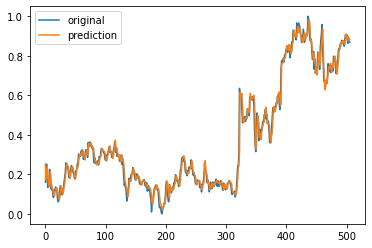

In [62]:
plt.plot(Y_train)
plt.plot(net(X_train).detach().numpy())
plt.legend(['original', 'prediction'])
plt.show()